In [85]:
import pickle as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.rcParams["text.usetex"] =True

#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

def results_per_group(results, group=None):
    if group is None:
        return np.mean([np.mean([results_f[uid] for uid in results_f]) for idx, results_f in enumerate(results)])
    else:
        return np.mean([np.mean([results_f[uid] for uid in group if uid in results_f]) for idx, results_f in enumerate(results)])

def recgap(x, y):
    return np.abs(np.array(x) - np.array(y))

def _gap(recommendation_list, item_popularity, user_profile_popularity):
    arp = np.mean([item_popularity.loc[str(iid)] for iid in recommendation_list])
    return (arp - user_profile_popularity) / user_profile_popularity

def _compute_gap(dirpath, item_popularity, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    gaps = []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            gap = dict()
            for uid, recs in recommendation_list.items():
                if uid not in impacted_users[idx]:
                    continue
                gap[uid] = _gap(recommendation_list=recs, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity[uid])
            gaps.append(gap)
        else:
            gap = dict()
            for uid, recs in recommendation_list.items():
                gap[uid] = _gap(recommendation_list=recs, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity[uid])
            gaps.append(gap)

    return gaps

def sort_files(path):
    base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            files.append(file)

    LEN_PREFIX = len(model_name)+1
    LEN_SUFFIX = len(".pkl")
    timestamps = [filename[LEN_PREFIX:-LEN_SUFFIX] for filename in files]
    sorted_timestamps = sorted(timestamps)
    sorted_files = [model_name + "-" + timestamp + ".pkl" for timestamp in sorted_timestamps]

    return sorted_files

def _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=None):
    cut = int(len(item_popularity) * 0.8)
    tail_items = set(item_popularity.sort_values(ascending=True).iloc[:cut].index.tolist())

    recall, ndcg, arp, aft = dict(), dict(), dict(), dict()
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        recall[uid] = len(groundtruth.loc[uid].intersection([str(iid) for iid in recs])) / len(groundtruth.loc[uid])

        dcg = 0.0
        idcg = 0.0
        for pos in range(1, len(recs)+1):
            item_at_i = str(recs[pos-1])
            rel_i = item_at_i in groundtruth.loc[uid]
            dcg += rel_i / np.log2(pos + 1)
            idcg += 1 / np.log2(pos + 1)
        ndcg[uid] = dcg / idcg
        arp[uid] = np.mean([item_popularity.loc[str(item_id)] for item_id in recs])
        aft[uid] = len(tail_items.intersection([str(iid) for iid in recs])) / len(recs)


    return recall, ndcg, arp, aft


def _analyze_recommendations(dirpath, item_popularity, groundtruth, impacted_users=None):
    files = sort_files(dirpath)
    recalls, ndcgs, arps, afts = [], [], [], []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=impacted_users[idx])
        else:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth)

        recalls.append(recall)
        ndcgs.append(ndcg)
        arps.append(arp)
        afts.append(aft)

    return recalls, ndcgs, arps, afts

def _get_impacted_users(dirpath_nodp, dirpath_dp):
    files_nodp = sort_files(dirpath_nodp)
    files_dp = sort_files(dirpath_dp)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_nodp, file_dp in zip(files_nodp, files_dp):
        with open(dirpath_nodp + "/" + file_nodp, "rb") as f:
            recommendation_list_nodp = pl.load(f)

        with open(dirpath_dp + "/" + file_dp, "rb") as f:
            recommendation_list_dp = pl.load(f)

        impacted_users_f, dist_f = [], []
        for uid, recs_dp in recommendation_list_dp.items():
            recs_nodp = recommendation_list_nodp[uid]

            dist = jaccard_distance(recs_nodp, recs_dp)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_dp))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)




In [13]:
def analyze(dataset_name, model_name, groundtruth, item_popularity):
    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp

    print("No DP: %.4f (recall), %.4f (ndcg), %.4f (arp), %.4f (aft)" % (results_per_group(recall_nodp), results_per_group(ndcg_nodp), results_per_group(arp_nodp), results_per_group(aft_nodp)))


    delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
    percentage_impacted_users, average_jaccard_distance = [], []
    for eps in [0.01, 0.1, 1, 2, 3, 4, 5][::-1]:
    #for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]:
        users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))

        results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=users)
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_eps

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(len(users)):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            """for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid]))
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid]))
                delta_arp_eps_f.append((arp_eps[file_idx][uid]))
                delta_aft_eps_f.append((aft_eps[file_idx][uid]))
            delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(np.nanmean(delta_aft_eps_f))"""
            for uid in intersection:
                delta_recall_eps_f.append((recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                delta_ndcg_eps_f.append((ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                delta_arp_eps_f.append((arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                delta_aft_eps_f.append((aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(100 * np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(100 * np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(100 * np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(100 * np.nanmean(delta_aft_eps_f))

        delta_recall.append(np.mean(delta_recall_eps))
        delta_ndcg.append(np.mean(delta_ndcg_eps))
        delta_arp.append(np.mean(delta_arp_eps))
        delta_aft.append(np.mean(delta_aft_eps))

        percentage_impacted_users.append(100 * frac_impacted)
        average_jaccard_distance.append(jacc)

        print("eps: %f -> %f%% (recall), %f%% (ndcg), %f%% (arp), %f%% (aft), %f (No. Users), %f (Jacc)" % (
            eps, delta_recall[-1], delta_ndcg[-1], delta_arp[-1], delta_aft[-1], percentage_impacted_users[-1], average_jaccard_distance[-1]))
    print()
    return delta_recall, delta_ndcg, delta_arp, delta_aft, percentage_impacted_users, average_jaccard_distance

In [14]:
dataset_name = "ml-1m"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

In [15]:
delta_recall, delta_ndcg, delta_arp, delta_aft = dict(), dict(), dict(), dict()
no_users, jacc_dist = dict(), dict()

"""recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["BPR"] = recall
delta_ndcg["BPR"] = ndcg
delta_arp["BPR"] = arp
delta_aft["BPR"] = aft
no_users["BPR"] = impacted_users
jacc_dist["BPR"] = jacc"""

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="ENMF", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["ENMF"] = recall
delta_ndcg["ENMF"] = ndcg
delta_arp["ENMF"] = arp
delta_aft["ENMF"] = aft
no_users["ENMF"] = impacted_users
jacc_dist["ENMF"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["LightGCN"] = recall
delta_ndcg["LightGCN"] = ndcg
delta_arp["LightGCN"] = arp
delta_aft["LightGCN"] = aft
no_users["LightGCN"] = impacted_users
jacc_dist["LightGCN"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name=dataset_name, model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["MultiVAE"] = recall
delta_ndcg["MultiVAE"] = ndcg
delta_arp["MultiVAE"] = arp
delta_aft["MultiVAE"] = aft
no_users["MultiVAE"] = impacted_users
jacc_dist["MultiVAE"] = jacc

No DP: 0.1697 (recall), 0.2641 (ndcg), 0.2172 (arp), 0.0025 (aft)
eps: 5.000000 -> 1.481142% (recall), 3.229627% (ndcg), 1.567845% (arp), -44.238729% (aft), 99.410108 (No. Users), 0.511811 (Jacc)
eps: 4.000000 -> 1.391720% (recall), 3.284976% (ndcg), 1.783187% (arp), -50.650891% (aft), 99.241094 (No. Users), 0.512890 (Jacc)
eps: 3.000000 -> -1.549163% (recall), -0.150509% (ndcg), 2.569472% (arp), -51.911690% (aft), 99.579122 (No. Users), 0.540777 (Jacc)
eps: 2.000000 -> -8.099214% (recall), -7.544594% (ndcg), 5.479865% (arp), -68.090756% (aft), 99.847556 (No. Users), 0.597360 (Jacc)
eps: 1.000000 -> -20.842819% (recall), -20.663668% (ndcg), 11.439280% (arp), -84.602010% (aft), 99.993372 (No. Users), 0.700592 (Jacc)
eps: 0.100000 -> -37.687966% (recall), -37.302279% (ndcg), 19.753692% (arp), -94.514673% (aft), 100.000000 (No. Users), 0.818337 (Jacc)
eps: 0.010000 -> -39.736690% (recall), -39.127183% (ndcg), 21.891295% (arp), -86.755757% (aft), 100.000000 (No. Users), 0.826120 (Jacc)

No

In [18]:
%matplotlib inline
all_eps = [0.01, 0.1, 1, 2, 3, 4, 5][::-1]
#all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1][::-1]

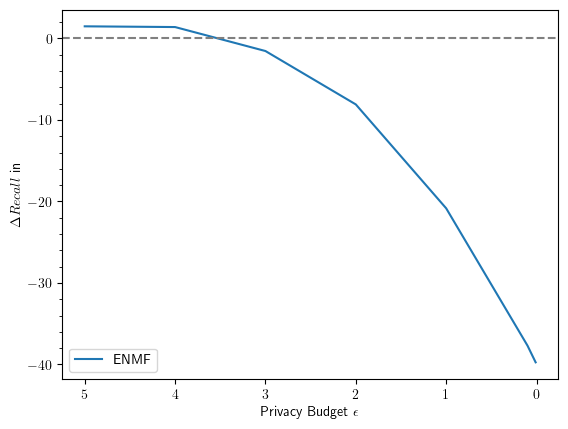

In [24]:
#plt.plot(all_eps, delta_recall["BPR"], label="BPR")
plt.plot(all_eps, delta_recall["ENMF"], label="ENMF")
#plt.plot(all_eps, delta_recall["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_recall["MultiVAE"], label="MultiVAE")
#plt.plot(all_eps, delta_recall["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta Recall$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().invert_xaxis()
plt.legend()

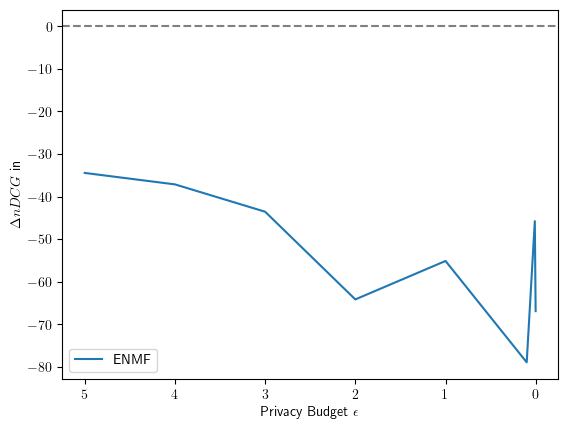

In [88]:
#plt.plot(all_eps, delta_ndcg["BPR"], label="BPR")
plt.plot(all_eps, delta_ndcg["ENMF"], label="ENMF")
#plt.plot(all_eps, delta_ndcg["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_ndcg["MultiVAE"], label="MultiVAE")
#plt.plot(all_eps, delta_ndcg["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta nDCG$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

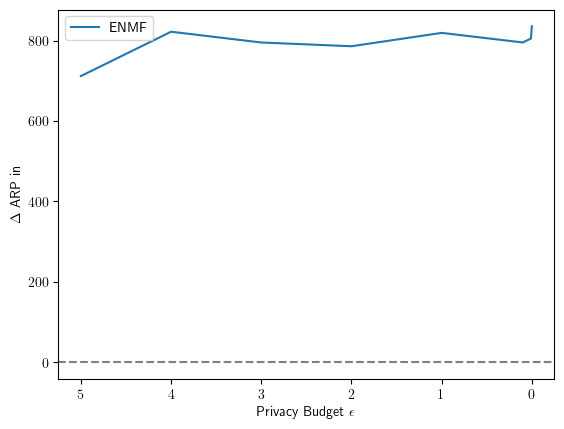

In [89]:
#plt.plot(all_eps, delta_arp["BPR"], label="BPR")
plt.plot(all_eps, delta_arp["ENMF"], label="ENMF")
#plt.plot(all_eps, delta_arp["LightGCN"], label="LightGCN")
#plt.plot(all_eps, delta_arp["MultiVAE"], label="MultiVAE")
#plt.plot(all_eps, delta_arp["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ ARP in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

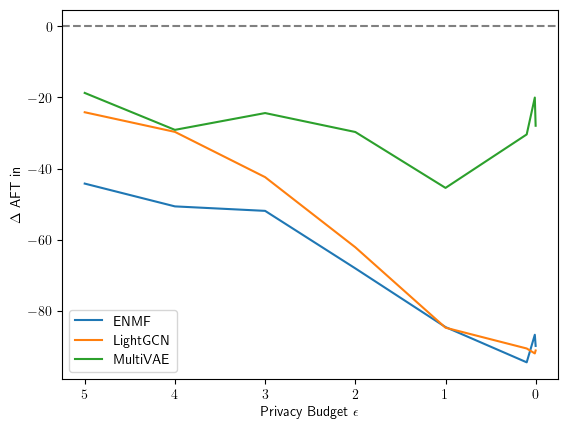

In [80]:
#plt.plot(all_eps, delta_aft["BPR"], label="BPR")
plt.plot(all_eps, delta_aft["ENMF"], label="ENMF")
plt.plot(all_eps, delta_aft["LightGCN"], label="LightGCN")
plt.plot(all_eps, delta_aft["MultiVAE"], label="MultiVAE")
#plt.plot(all_eps, delta_aft["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ AFT in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

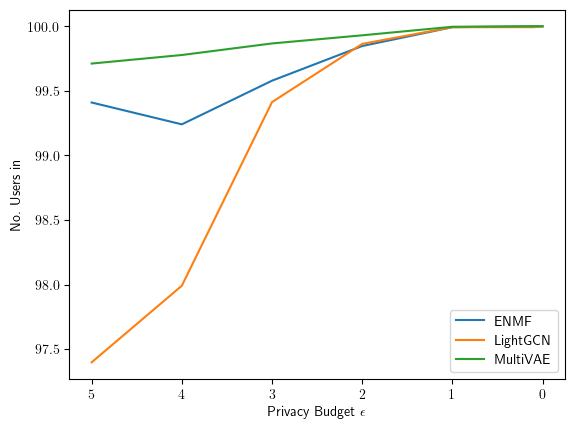

In [81]:
#plt.plot(all_eps, no_users["BPR"], label="BPR")
plt.plot(all_eps, no_users["ENMF"], label="ENMF")
plt.plot(all_eps, no_users["LightGCN"], label="LightGCN")
plt.plot(all_eps, no_users["MultiVAE"], label="MultiVAE")
#plt.plot(all_eps, no_users["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("No. Users in %")
plt.gca().invert_xaxis()
plt.legend()

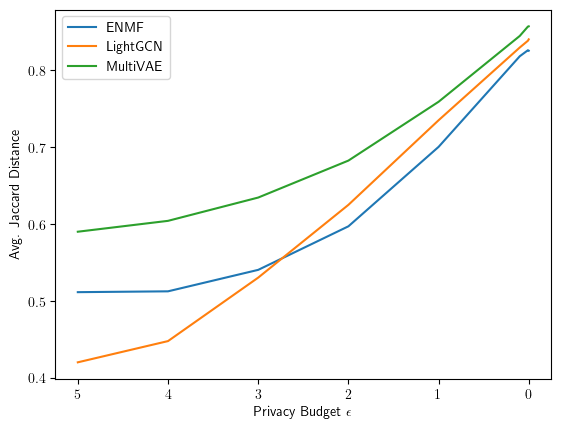

In [82]:
#plt.plot(all_eps, jacc_dist["BPR"], label="BPR")
plt.plot(all_eps, jacc_dist["ENMF"], label="ENMF")
plt.plot(all_eps, jacc_dist["LightGCN"], label="LightGCN")
plt.plot(all_eps, jacc_dist["MultiVAE"], label="MultiVAE")
#plt.plot(all_eps, jacc_dist["Pop"], label="Pop")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("Avg. Jaccard Distance")
plt.gca().invert_xaxis()
plt.legend()

In [26]:
def get_results(dataset_name, algos):
    test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
    test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    test_df["user_id"] = test_df["user_id"].astype(str)
    test_df["item_id"] = test_df["item_id"].astype(str)
    groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

    df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
    df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()


    recall, arp, aft = dict(), dict(), dict()
    for algo in algos:
        recall_a, _, arp_a, aft_a, _, _ = analyze(dataset_name=dataset_name, model_name=algo, groundtruth=groundtruth, item_popularity=item_popularity)
        recall[algo] = recall_a
        arp[algo] = arp_a
        aft[algo] = aft_a

    return recall, arp, aft

recall_ml1m, arp_ml1m, aft_ml1m = get_results(dataset_name="ml-1m", algos=["ENMF", "LightGCN", "MultiVAE"])
recall_lfm, arp_lfm, aft_lfm = get_results(dataset_name="LFM-3k", algos=["ENMF", "LightGCN", "MultiVAE"])
recall_amazon, arp_amazon, aft_amazon = get_results(dataset_name="grocery", algos=["ENMF", "LightGCN", "MultiVAE"])

No DP: 0.1697 (recall), 0.2641 (ndcg), 0.2172 (arp), 0.0025 (aft)
eps: 5.000000 -> 1.481142% (recall), 3.229627% (ndcg), 1.567845% (arp), -44.238729% (aft), 99.410108 (No. Users), 0.511811 (Jacc)
eps: 4.000000 -> 1.391720% (recall), 3.284976% (ndcg), 1.783187% (arp), -50.650891% (aft), 99.241094 (No. Users), 0.512890 (Jacc)
eps: 3.000000 -> -1.549163% (recall), -0.150509% (ndcg), 2.569472% (arp), -51.911690% (aft), 99.579122 (No. Users), 0.540777 (Jacc)
eps: 2.000000 -> -8.099214% (recall), -7.544594% (ndcg), 5.479865% (arp), -68.090756% (aft), 99.847556 (No. Users), 0.597360 (Jacc)
eps: 1.000000 -> -20.842819% (recall), -20.663668% (ndcg), 11.439280% (arp), -84.602010% (aft), 99.993372 (No. Users), 0.700592 (Jacc)
eps: 0.100000 -> -37.687966% (recall), -37.302279% (ndcg), 19.753692% (arp), -94.514673% (aft), 100.000000 (No. Users), 0.818337 (Jacc)
eps: 0.010000 -> -39.736690% (recall), -39.127183% (ndcg), 21.891295% (arp), -86.755757% (aft), 100.000000 (No. Users), 0.826120 (Jacc)

No

In [43]:
print([(model, recalls[-1])for model, recalls in recall_ml1m.items()])
print([(model, recalls[-1])for model, recalls in recall_lfm.items()])
print([(model, recalls[-1])for model, recalls in recall_amazon.items()])

[('ENMF', -39.736690410351386), ('LightGCN', -40.01906908881053), ('MultiVAE', -43.27735393417695)]
[('ENMF', -48.98956690615172), ('LightGCN', -53.12388627329867), ('MultiVAE', -66.32603574159856)]
[('ENMF', -72.305504707558), ('LightGCN', -59.70754942859291), ('MultiVAE', -60.13629949852374)]


In [78]:
print([(model, arps[-1])for model, arps in arp_ml1m.items()])
print([(model, arps[-1])for model, arps in arp_lfm.items()])
print([(model, arps[-1])for model, arps in arp_amazon.items()])

[('ENMF', 21.891294657952972), ('LightGCN', 75.91629110886068), ('MultiVAE', 23.00861456687334)]
[('ENMF', 51.34036836954988), ('LightGCN', 200.6772292469635), ('MultiVAE', 185.95111201120784)]
[('ENMF', 148.33658964161492), ('LightGCN', 110.67524095310937), ('MultiVAE', 272.73821945095244)]


In [70]:
%matplotlib qt

def f(x):
    return x

all_eps = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5][1:]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, f(recall_ml1m["ENMF"][::-1]), color="C0", linewidth=3, linestyle="dotted")
ax1.plot(all_eps, f(recall_ml1m["LightGCN"][::-1]), color="C1", linewidth=3, linestyle="dashed")
ax1.plot(all_eps, f(recall_ml1m["MultiVAE"][::-1]), color="C2", linewidth=3, linestyle="dashdot")
ax1.invert_xaxis()

ax2.plot(all_eps, f(recall_lfm["ENMF"][::-1]), color="C0", linewidth=3, linestyle="dotted")
ax2.plot(all_eps, f(recall_lfm["LightGCN"][::-1]), color="C1", linewidth=3, linestyle="dashed")
ax2.plot(all_eps, f(recall_lfm["MultiVAE"][::-1]), color="C2", linewidth=3, linestyle="dashdot")
ax2.invert_xaxis()

ax3.plot(all_eps, f(recall_amazon["ENMF"][::-1]), color="C0", linewidth=3, linestyle="dotted")
ax3.plot(all_eps, f(recall_amazon["LightGCN"][::-1]), color="C1", linewidth=3, linestyle="dashed")
ax3.plot(all_eps, f(recall_amazon["MultiVAE"][::-1]), color="C2", linewidth=3, linestyle="dashdot")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta Recall$ in \%", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LastFM User Groups}")
ax3.set_title(r"\emph{Grocery \& Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="dotted"))
lines.append(Line2D([0], [0], color="C1", linestyle="dashed"))
lines.append(Line2D([0], [0], color="C2", linestyle="dashdot"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])

plt.savefig("plots/delta_recall.png", dpi=300)

In [76]:
%matplotlib qt

def f(x):
    #return np.log10(x)
    return x



fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, f(arp_ml1m["ENMF"][::-1]), color="C0", linewidth=3, linestyle="dotted")
ax1.plot(all_eps, f(arp_ml1m["LightGCN"][::-1]), color="C1", linewidth=3, linestyle="dashed")
ax1.plot(all_eps, f(arp_ml1m["MultiVAE"][::-1]), color="C2", linewidth=3, linestyle="dashdot")
ax1.invert_xaxis()

ax2.plot(all_eps, f(arp_lfm["ENMF"][::-1]), color="C0", linewidth=3, linestyle="dotted")
ax2.plot(all_eps, f(arp_lfm["LightGCN"][::-1]), color="C1", linewidth=3, linestyle="dashed")
ax2.plot(all_eps, f(arp_lfm["MultiVAE"][::-1]), color="C2", linewidth=3, linestyle="dashdot")
ax2.invert_xaxis()

ax3.plot(all_eps, f(arp_amazon["ENMF"][::-1]), color="C0", linewidth=3, linestyle="dotted")
ax3.plot(all_eps, f(arp_amazon["LightGCN"][::-1]), color="C1", linewidth=3, linestyle="dashed")
ax3.plot(all_eps, f(arp_amazon["MultiVAE"][::-1]), color="C2", linewidth=3, linestyle="dashdot")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta ARP$ in \%", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LastFM User Groups}")
ax3.set_title(r"\emph{Grocery \& Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

#ax1.set_yscale('symlog')
#ax2.set_yscale('symlog')
##ax3.set_yscale('symlog')

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="dotted"))
lines.append(Line2D([0], [0], color="C1", linestyle="dashed"))
lines.append(Line2D([0], [0], color="C2", linestyle="dashdot"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])
plt.savefig("plots/delta_arp.png", dpi=300)

In [34]:
%matplotlib qt

def f(x):
    return x

all_eps = [0.01, 0.1, 1, 2, 3, 4, 5][1:]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, f(aft_ml1m["ENMF"][::-1][1:]), color="C0", linewidth=2)
ax1.plot(all_eps, f(aft_ml1m["LightGCN"][::-1][1:]), color="C1", linewidth=2)
ax1.plot(all_eps, f(aft_ml1m["MultiVAE"][::-1][1:]), color="C2", linewidth=2)
ax1.invert_xaxis()

ax2.plot(all_eps, f(aft_lfm["ENMF"][::-1][1:]), color="C0", linewidth=2)
ax2.plot(all_eps, f(aft_lfm["LightGCN"][::-1][1:]), color="C1", linewidth=2)
ax2.plot(all_eps, f(aft_lfm["MultiVAE"][::-1][1:]), color="C2", linewidth=2)
ax2.invert_xaxis()

ax3.plot(all_eps, f(aft_amazon["ENMF"][::-1][1:]), color="C0", linewidth=2)
ax3.plot(all_eps, f(aft_amazon["LightGCN"][::-1][1:]), color="C1", linewidth=2)
ax3.plot(all_eps, f(aft_amazon["MultiVAE"][::-1][1:]), color="C2", linewidth=2)
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta AFT$ in \%", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LFM User Groups}")
ax3.set_title(r"\emph{Grocery and Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="solid"))
lines.append(Line2D([0], [0], color="C1", linestyle="solid"))
lines.append(Line2D([0], [0], color="C2", linestyle="solid"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])
plt.savefig("plots/delta_aft.png", dpi=300)

In [13]:
dataset_name = "LFM-3k"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
test_df["user_id"] = test_df["user_id"].astype(str)
test_df["item_id"] = test_df["item_id"].astype(str)

groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

In [14]:
def analyze_groups(dataset_name, model_name, groundtruth, item_popularity, group1, group2, absolute_values=False, compute_diff=True):
    def recgap(x, y):
        return np.abs(np.array(x) - np.array(y))

    def get_deltas(results_nodp, results_dp, abs=False):
        recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_dp

        delta_recall_eps, delta_ndcg_eps, delta_arp_eps, delta_aft_eps = [], [], [], []
        for file_idx in range(5):
            intersection = set(recall_nodp[file_idx].keys()).intersection(recall_eps[file_idx].keys())
            delta_recall_eps_f, delta_ndcg_eps_f, delta_arp_eps_f, delta_aft_eps_f = [], [], [], []
            for uid in intersection:
                if abs:
                    delta_recall_eps_f.append(recall_eps[file_idx][uid])
                    delta_ndcg_eps_f.append(ndcg_eps[file_idx][uid])
                    delta_arp_eps_f.append(arp_eps[file_idx][uid])
                    delta_aft_eps_f.append(aft_eps[file_idx][uid])
                else:
                    delta_recall_eps_f.append(100 * (recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                    delta_ndcg_eps_f.append(100 * (ndcg_eps[file_idx][uid] - ndcg_nodp[file_idx][uid]) / ndcg_nodp[file_idx][uid] if ndcg_nodp[file_idx][uid] != 0 else np.nan)
                    delta_arp_eps_f.append(100 * (arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
                    delta_aft_eps_f.append(100 * (aft_eps[file_idx][uid] - aft_nodp[file_idx][uid]) / aft_nodp[file_idx][uid] if aft_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(np.nanmean(delta_recall_eps_f))
            delta_ndcg_eps.append(np.nanmean(delta_ndcg_eps_f))
            delta_arp_eps.append(np.nanmean(delta_arp_eps_f))
            delta_aft_eps.append(np.nanmean(delta_aft_eps_f))

        return np.mean(delta_recall_eps), np.mean(delta_ndcg_eps), np.mean(delta_arp_eps), np.mean(delta_aft_eps)

    print()
    print(model_name + " (" + dataset_name + ")")

    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp

    print("No DP: %.4f/%.4f (recall), %.4f/%.4f (ndcg), %.4f/%.4f (arp), %.4f/%.4f (aft)" % (results_per_group(recall_nodp, group1), results_per_group(recall_nodp, group2), results_per_group(ndcg_nodp, group1), results_per_group(ndcg_nodp, group2), results_per_group(arp_nodp, group1), results_per_group(arp_nodp, group2), results_per_group(aft_nodp, group1), results_per_group(aft_nodp, group2)))

    delta_recall1, delta_ndcg1, delta_arp1, delta_aft1 = [], [], [], []
    delta_recall2, delta_ndcg2, delta_arp2, delta_aft2 = [], [], [], []
    for eps in [0.1, 1, 2, 5][::-1]:
        users, frac, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        print([len(g) for g in group1_and_impacted])
        print([len(g) for g in group2_and_impacted])
        print([len(u) for u in users])

        results1_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group1_and_impacted)
        results2_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=group2_and_impacted)

        delta_recall1_eps, delta_ndcg1_eps, delta_arp1_eps, delta_aft1_eps = get_deltas(results_nodp=results_nodp, results_dp=results1_eps, abs=absolute_values)
        delta_recall2_eps, delta_ndcg2_eps, delta_arp2_eps, delta_aft2_eps = get_deltas(results_nodp=results_nodp, results_dp=results2_eps, abs=absolute_values)

        delta_recall1.append(delta_recall1_eps)
        delta_ndcg1.append(delta_ndcg1_eps)
        delta_arp1.append(delta_arp1_eps)
        delta_aft1.append(delta_aft1_eps)

        delta_recall2.append(delta_recall2_eps)
        delta_ndcg2.append(delta_ndcg2_eps)
        delta_arp2.append(delta_arp2_eps)
        delta_aft2.append(delta_aft2_eps)

        if absolute_values:
            print("eps: %f -> %.2f/%.2f (recall), %.2f/%.2f (ndcg), %.2f/%.2f (arp), %.2f/%.2f (aft)" % (eps, delta_recall1[-1], delta_recall2[-1], delta_ndcg1[-1], delta_ndcg2[-1], delta_arp1[-1], delta_arp2[-1], delta_aft1[-1], delta_aft2[-1]))
        else:
            print("eps: %f -> %.2f%%/%.2f%% (recall), %.2f%%/%.2f%% (ndcg), %.2f%%/%.2f%% (arp), %.2f%%/%.2f%% (aft)" % (eps, delta_recall1[-1], delta_recall2[-1], delta_ndcg1[-1], delta_ndcg2[-1], delta_arp1[-1], delta_arp2[-1], delta_aft1[-1], delta_aft2[-1]))

    if compute_diff:
        print("Diff Recall: %s" % recgap(delta_recall1, delta_recall2))
        print("Diff nDCG: %s" % recgap(delta_ndcg1, delta_ndcg2))
        print("Diff ARP: %s" % recgap(delta_arp1, delta_arp2))
        print("Diff AFT: %s" % recgap(delta_aft1, delta_aft2))

        return (delta_recall1, delta_ndcg1, delta_arp1, delta_aft1), (delta_recall2, delta_ndcg2, delta_arp2, delta_aft2), (recgap(delta_recall1, delta_recall2), recgap(delta_ndcg1, delta_ndcg2), recgap(delta_arp1, delta_arp2), recgap(delta_aft1, delta_aft2))
    else:
        return (delta_recall1, delta_ndcg1, delta_arp1, delta_aft1), (delta_recall2, delta_ndcg2, delta_arp2, delta_aft2)

#analyze_groups(dataset_name=dataset_name, model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)
#analyze_groups(dataset_name=dataset_name, model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)
analyze_groups(dataset_name=dataset_name, model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users,compute_diff=True)
#analyze_groups(dataset_name=dataset_name, model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity, group1=low_users, group2=high_users, compute_diff=True)


LightGCN (LFM-3k)
No DP: 0.0401/0.1525 (recall), 0.1123/0.2353 (ndcg), 0.0404/0.1184 (arp), 0.1227/0.0004 (aft)
[599, 598, 598, 598, 598]
[588, 580, 575, 576, 581]
[2981, 2971, 2961, 2966, 2968]


C:\Users\pmuellner\AppData\Local\Temp\ipykernel_19352\1900368229.py:27: RuntimeWarning: Mean of empty slice
  delta_aft_eps.append(np.nanmean(delta_aft_eps_f))


eps: 5.000000 -> -12.57%/1.58% (recall), -6.37%/2.00% (ndcg), 38.22%/-0.52% (arp), -3.40%/nan% (aft)
[599, 599, 599, 599, 599]
[594, 596, 595, 597, 596]
[2993, 2995, 2994, 2996, 2996]
eps: 2.000000 -> -33.08%/-13.45% (recall), -28.32%/-14.00% (ndcg), 96.40%/1.39% (arp), 25.78%/nan% (aft)
[599, 599, 599, 599, 599]
[596, 597, 597, 597, 597]
[2996, 2997, 2997, 2997, 2997]
eps: 1.000000 -> -49.84%/-27.60% (recall), -46.64%/-29.00% (ndcg), 221.69%/13.74% (arp), 43.71%/nan% (aft)
[599, 599, 599, 599, 599]
[597, 597, 597, 597, 597]
[2997, 2997, 2997, 2997, 2997]
eps: 0.100000 -> -76.24%/-44.56% (recall), -74.18%/-46.14% (ndcg), 578.99%/22.70% (arp), 24.54%/nan% (aft)
Diff Recall: [14.15350865 19.62796378 22.23681838 31.6796175 ]
Diff nDCG: [ 8.36404327 14.31975726 17.63381489 28.0438291 ]
Diff ARP: [ 38.74016728  95.00706228 207.95335381 556.28573293]
Diff AFT: [nan nan nan nan]


(([-12.570517317120705,
   -33.08045899032271,
   -49.83556890027805,
   -76.24212292949431],
  [-6.365851713413898,
   -28.323443129120733,
   -46.63643620908028,
   -74.18179591790684],
  [38.22105765483959,
   96.39564721297056,
   221.69084336957297,
   578.9868557863911],
  [-3.399999024064518,
   25.784768662619967,
   43.71355136131479,
   24.536464067643447]),
 ([1.5829913362791657,
   -13.452495208514957,
   -27.598750523585768,
   -44.56250542539433],
  [1.9981915588722459,
   -14.003685866526041,
   -29.002621316261912,
   -46.13796681543192],
  [-0.5191096280410396,
   1.3885849375340722,
   13.73748956061917,
   22.701122855285917],
  [nan, nan, nan, nan]),
 (array([14.15350865, 19.62796378, 22.23681838, 31.6796175 ]),
  array([ 8.36404327, 14.31975726, 17.63381489, 28.0438291 ]),
  array([ 38.74016728,  95.00706228, 207.95335381, 556.28573293]),
  array([nan, nan, nan, nan])))

In [31]:
def analyze_groups_gap(dataset_name, model_name, user_profile_pop, item_popularity, group1, group2, absolute_values=False, compute_diff=True):
    def get_deltas(gaps_nodp, gaps_eps, abs=False):
        delta_gap_eps = []
        for file_idx in range(5):
            intersection = set(gaps_nodp[file_idx].keys()).intersection(gaps_eps[file_idx].keys())
            delta_gap_eps_f = []
            for uid in intersection:
                if abs:
                    delta_gap_eps_f.append(gaps_eps[file_idx][uid])
                else:
                    delta_gap_eps_f.append(100 * np.abs(gaps_eps[file_idx][uid] - gaps_nodp[file_idx][uid]) / gaps_nodp[file_idx][uid] if gaps_nodp[file_idx][uid] != 0 else np.nan)
            delta_gap_eps.append(np.nanmean(delta_gap_eps_f))

        return np.mean(delta_gap_eps)
    print()
    print(model_name + " (" + dataset_name + ")")
    dir = "saved/" + dataset_name + "/" + model_name + "/"

    gaps_nodp = _compute_gap(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop)
    print("No DP: %.4f/%.4f (delta gap)" % (results_per_group(gaps_nodp, group1), results_per_group(gaps_nodp, group2)))


    delta_gap1, delta_gap2 = [], []
    for eps in [0.1, 1, 2, 5][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        gaps1_eps = _compute_gap(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, impacted_users=group1_and_impacted)
        gaps2_eps = _compute_gap(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, impacted_users=group2_and_impacted)
        delta_gap1_eps = get_deltas(gaps_nodp=gaps_nodp, gaps_eps=gaps1_eps, abs=absolute_values)
        delta_gap2_eps = get_deltas(gaps_nodp=gaps_nodp, gaps_eps=gaps2_eps, abs=absolute_values)

        delta_gap1.append(delta_gap1_eps)
        delta_gap2.append(delta_gap2_eps)

        if absolute_values:
            print("eps: %f -> %.4f/%.4f (delta gap)" % (eps, delta_gap1[-1], delta_gap2[-1]))
        else:
            print("eps: %f -> %.4f%%/%.4f%% (delta gap)" % (eps, delta_gap1[-1], delta_gap2[-1]))
    #print()
    if compute_diff:
        print("Diff Delta GAP: %s" % recgap(delta_gap1, delta_gap2))
        return delta_gap1, delta_gap2, recgap(delta_gap1, delta_gap2)
    else:
        return delta_gap1, delta_gap2


dataset_name = "sportsandoutdoors"

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

#analyze_groups_gap(dataset_name=dataset_name, model_name="BPR", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
analyze_groups_gap(dataset_name=dataset_name, model_name="ENMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
#analyze_groups_gap(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
#analyze_groups_gap(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)


ENMF (sportsandoutdoors)
No DP: 3.4146/1.1878 (delta gap)


IndexError: list index out of range

In [190]:
def analyze_poplift(dataset_name, model_name, user_profile_pop, item_popularity, group1, group2):
    def _compute_poplift(dirpath, item_popularity, user_profile_popularity, group):
        files = sort_files(dirpath)
        poplifts = []
        for idx, file in enumerate(files):
            with open(dirpath + "/" + file, "rb") as f:
                recommendation_list = pl.load(f)
                arp_g, upp_g = [], []
                for uid, recs in recommendation_list.items():
                    if uid not in group[idx]:
                        continue

                    arp_g.append(np.mean([item_popularity.loc[str(iid)] for iid in recs]))
                    upp_g.append(user_profile_popularity.loc[uid])

                poplifts.append((np.mean(arp_g) - np.mean(upp_g)) / np.mean(upp_g))
        return np.mean(poplifts)

    print()
    print(model_name + " (" + dataset_name + ")")
    dir = "saved/" + dataset_name + "/" + model_name + "/"

    pl1_nodp = _compute_poplift(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=[group1] * 5)
    pl2_nodp = _compute_poplift(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=[group2] * 5)
    #print("No DP: %.4f/%.4f (PopLift), %.4f" % (pl1_nodp, pl2_nodp, np.abs(pl1_nodp - pl2_nodp)))
    print("No DP: %.4f/%.4f & %.4f" % (pl1_nodp, pl2_nodp, np.abs(pl1_nodp - pl2_nodp)))

    poplifts1, poplifts2 = [], []
    for eps in [0.1, 1, 2, 5][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(group1))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(group2))

        pl1_eps = _compute_poplift(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=group1_and_impacted)
        pl2_eps = _compute_poplift(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=group2_and_impacted)

        poplifts1.append(pl1_eps)
        poplifts2.append(pl2_eps)

        #print("eps: %f -> %.4f/%.4f (PopLift), %.4f (Gap)" % (eps, poplifts1[-1], poplifts2[-1], np.abs(poplifts1[-1] - poplifts2[-1])))
        #print("eps: %f -> %.4f/%.4f & %.4f" % (eps, poplifts1[-1], poplifts2[-1], np.abs(poplifts1[-1] - poplifts2[-1])))
        #print("eps: %f -> %.4f/%.4f & %.4f" % (eps, poplifts1[-1], poplifts2[-1], (poplifts1[-1] - poplifts2[-1])))

        delta_pl1 = (poplifts1[-1] - pl1_nodp)
        delta_pl2 = (poplifts2[-1] - pl2_nodp)
        delta_gap = np.abs(poplifts1[-1] - poplifts2[-1]) - np.abs(pl1_nodp - pl2_nodp)

        print("eps: %f -> %.4f/%.4f & %.4f" % (eps, delta_pl1, delta_pl2, delta_gap))


    return poplifts1, poplifts2

dataset_name = "LFM-3k"

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

user_profile_size = df.groupby("user_id").size()
print(user_profile_size.loc[low_users].mean(), user_profile_size.loc[high_users].mean())

#analyze_groups_gap(dataset_name=dataset_name, model_name="BPR", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users, absolute_values=True, compute_diff=True)
analyze_poplift(dataset_name=dataset_name, model_name="ENMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users)
analyze_poplift(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users)
analyze_poplift(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=low_users, group2=high_users)

152.0033388981636 77.12020033388981

ENMF (LFM-3k)
No DP: 4.1028/1.1578 & 2.9450
eps: 5.000000 -> -0.0056/0.0051 & -0.0107
eps: 2.000000 -> 0.4464/0.0756 & 0.3708
eps: 1.000000 -> 1.1283/0.1732 & 0.9551
eps: 0.100000 -> 1.6189/0.2870 & 1.3319

LightGCN (LFM-3k)
No DP: 2.7848/1.3273 & 1.4576
eps: 5.000000 -> 0.0104/-0.0482 & 0.0586
eps: 2.000000 -> 0.3668/-0.0379 & 0.4047
eps: 1.000000 -> 1.0269/0.1994 & 0.8275
eps: 0.100000 -> 2.9384/0.3187 & 2.6197

MultiVAE (LFM-3k)
No DP: 0.7441/0.9092 & 0.1651
eps: 5.000000 -> -0.0198/-0.0164 & 0.0034
eps: 2.000000 -> -0.5547/0.1432 & 0.6979
eps: 1.000000 -> -0.4046/0.4047 & 0.8093
eps: 0.100000 -> 0.3319/0.8781 & 0.5462


([0.7243526746758786,
  0.1894142384216815,
  0.3395276819932526,
  1.0760348244948403],
 [0.8928299515941525,
  1.0523592826074968,
  1.3138814572025197,
  1.7873084372085473])

In [178]:
dataset_name = "LFM-3k"
model_name = "MultiVAE"

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))
cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())
frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"
cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

#dirpath = "saved/" + dataset_name + "/" + model_name + "/nodp"
dirpath = "saved/" + dataset_name + "/" + model_name + "/e0.1"
files = sort_files(dirpath)

frac_tail_items = []
item_coverage_low, item_coverage_high = [], []
arp_low, arp_high = [], []
for idx, file in enumerate(files):
    item_coverage_low_f, item_coverage_high_f = set(), set()
    arp_low_f, arp_high_f = [], []
    frac_tail_items_f = []
    with open(dirpath + "/" + file, "rb") as f:
        recommendation_list = pl.load(f)
        for uid, recs in recommendation_list.items():
            if uid in low_users:
                item_coverage_low_f = item_coverage_low_f.union(recs)
                arp_low_f.append(np.mean([item_popularity.loc[str(iid)] for iid in recs]))
            elif uid in high_users:
                item_coverage_high_f = item_coverage_high_f.union(recs)
                arp_high_f.append(np.mean([item_popularity.loc[str(iid)] for iid in recs]))

        all_items = item_coverage_low_f#.union(item_coverage_high)
        tail_items = all_items.difference(head_items)
        frac_tail_items_f.append(len(tail_items))

    item_coverage_low.append(len(item_coverage_low_f))
    item_coverage_high.append(len(item_coverage_high_f))
    arp_low.append(np.mean(arp_low_f))
    arp_high.append(np.mean(arp_high_f))
    frac_tail_items.append(frac_tail_items_f)
print(np.mean(item_coverage_low), np.mean(item_coverage_high))
print(np.mean(arp_low), np.mean(arp_high))
print(np.mean(frac_tail_items))

4369.4 450.6
0.021845701488698792 0.13625621717568612
2600.2


In [38]:
poplift_ml, poplift_lfm, poplift_amazon = dict(), dict(), dict()

dataset_name = "ml-1m"
df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))
all_users = user_profile_pop.index.tolist()

poplift_ml["ENMF"], _ = analyze_poplift(dataset_name=dataset_name, model_name="ENMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)
poplift_ml["LightGCN"], _ = analyze_poplift(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)
poplift_ml["MultiVAE"], _ = analyze_poplift(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)


dataset_name = "LFM-3k"
df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))
all_users = user_profile_pop.index.tolist()

poplift_lfm["ENMF"], _ = analyze_poplift(dataset_name=dataset_name, model_name="ENMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)
poplift_lfm["LightGCN"], _ = analyze_poplift(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)
poplift_lfm["MultiVAE"], _ = analyze_poplift(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)

dataset_name = "grocery"
df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))
all_users = user_profile_pop.index.tolist()

poplift_amazon["ENMF"], _ = analyze_poplift(dataset_name=dataset_name, model_name="ENMF", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)
poplift_amazon["LightGCN"], _ = analyze_poplift(dataset_name=dataset_name, model_name="LightGCN", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)
poplift_amazon["MultiVAE"], _ = analyze_poplift(dataset_name=dataset_name, model_name="MultiVAE", user_profile_pop=user_profile_pop, item_popularity=item_popularity, group1=all_users, group2=all_users)


ENMF (ml-1m)
No DP: 0.7084/0.7084 & 0.0000
eps: 5.000000 -> 0.7157/0.7157 & 0.0000
eps: 4.000000 -> 0.7189/0.7189 & 0.0000
eps: 3.000000 -> 0.7272/0.7272 & 0.0000
eps: 2.000000 -> 0.7661/0.7661 & 0.0000
eps: 1.000000 -> 0.8473/0.8473 & 0.0000
eps: 0.100000 -> 0.9618/0.9618 & 0.0000
eps: 0.010000 -> 0.9933/0.9933 & 0.0000
eps: 0.001000 -> 0.9908/0.9908 & 0.0000

LightGCN (ml-1m)
No DP: 0.5405/0.5405 & 0.0000
eps: 5.000000 -> 0.5765/0.5765 & 0.0000
eps: 4.000000 -> 0.5886/0.5886 & 0.0000
eps: 3.000000 -> 0.6412/0.6412 & 0.0000
eps: 2.000000 -> 0.7383/0.7383 & 0.0000
eps: 1.000000 -> 0.9672/0.9672 & 0.0000
eps: 0.100000 -> 1.2468/1.2468 & 0.0000
eps: 0.010000 -> 1.3141/1.3141 & 0.0000
eps: 0.001000 -> 1.3008/1.3008 & 0.0000

MultiVAE (ml-1m)
No DP: 0.5657/0.5657 & 0.0000
eps: 5.000000 -> 0.6002/0.6002 & 0.0000
eps: 4.000000 -> 0.6638/0.6638 & 0.0000
eps: 3.000000 -> 0.6219/0.6219 & 0.0000
eps: 2.000000 -> 0.6938/0.6938 & 0.0000
eps: 1.000000 -> 0.7758/0.7758 & 0.0000
eps: 0.100000 -> 0.8

In [99]:
print([(model, poplifts[-2])for model, poplifts in poplift_ml.items()])
print([(model, poplifts[-2])for model, poplifts in poplift_lfm.items()])
print([(model, poplifts[-2])for model, poplifts in poplift_amazon.items()])

[('ENMF', 0.9932990168257934), ('LightGCN', 1.314114915648702), ('MultiVAE', 0.7827698715525143)]
[('ENMF', 2.437028895080134), ('LightGCN', 2.7901041329297582), ('MultiVAE', 2.375623384795756)]
[('ENMF', 2.3910490394795327), ('LightGCN', 2.384921877875038), ('MultiVAE', 3.7464884341539273)]


In [100]:
nodp_poplift_ml = {"ENMF": 0.7084, "LightGCN": 0.5405, "MultiVAE": 0.5657}
nodp_poplift_lfm = {"ENMF": 1.8816, "LightGCN": 1.7585, "MultiVAE": 0.9864}
nodp_poplift_amazon = {"ENMF": 0.5143, "LightGCN": 1.1796, "MultiVAE": 0.6734}

delta_poplift_ml, delta_poplift_lfm, delta_poplift_amazon = defaultdict(list), defaultdict(list), defaultdict(list)
for model, values in poplift_ml.items():
    delta_poplift_ml[model] = (100 * (np.array(values) - nodp_poplift_ml[model]) / nodp_poplift_ml[model])
for model, values in poplift_lfm.items():
    delta_poplift_lfm[model] = (100 * (np.array(values) - nodp_poplift_lfm[model]) / nodp_poplift_lfm[model])
for model, values in poplift_amazon.items():
    delta_poplift_amazon[model] = (100 * (np.array(values) - nodp_poplift_amazon[model]) / nodp_poplift_amazon[model])

print([(model, poplifts[-2]) for model, poplifts in delta_poplift_ml.items()])
print([(model, poplifts[-2]) for model, poplifts in delta_poplift_lfm.items()])
print([(model, poplifts[-2]) for model, poplifts in delta_poplift_amazon.items()])

[('ENMF', 40.21725251634575), ('LightGCN', 143.1294941070679), ('MultiVAE', 38.37190587811814)]
[('ENMF', 29.51896763818741), ('LightGCN', 58.663868804649326), ('MultiVAE', 140.83773162974006)]
[('ENMF', 364.9132878630241), ('LightGCN', 102.18055933155628), ('MultiVAE', 456.35408882594703)]


In [98]:
delta_poplift_ml["ENMF"]

array([ 1.03516416,  1.47734032,  2.65539449,  8.14150866, 19.61318598,
       35.7646688 , 40.21725252, 39.8678754 ])

In [95]:
%matplotlib qt

def f(x):
    return x

all_eps = [0.01, 0.1, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, f(delta_poplift_ml["ENMF"][::-1][1:]), color="C0", linewidth=3, linestyle="dotted")
ax1.plot(all_eps, f(delta_poplift_ml["LightGCN"][::-1][1:]), color="C1", linewidth=3, linestyle="dashed")
ax1.plot(all_eps, f(delta_poplift_ml["MultiVAE"][::-1][1:]), color="C2", linewidth=3, linestyle="dashdot")
ax1.invert_xaxis()

ax2.plot(all_eps, f(delta_poplift_lfm["ENMF"][::-1][1:]), color="C0", linewidth=3, linestyle="dotted")
ax2.plot(all_eps, f(delta_poplift_lfm["LightGCN"][::-1][1:]), color="C1", linewidth=3, linestyle="dashed")
ax2.plot(all_eps, f(delta_poplift_lfm["MultiVAE"][::-1][1:]), color="C2", linewidth=3, linestyle="dashdot")
ax2.invert_xaxis()

ax3.plot(all_eps, f(delta_poplift_amazon["ENMF"][::-1][1:]), color="C0", linewidth=3, linestyle="dotted")
ax3.plot(all_eps, f(delta_poplift_amazon["LightGCN"][::-1][1:]), color="C1", linewidth=3, linestyle="dashed")
ax3.plot(all_eps, f(delta_poplift_amazon["MultiVAE"][::-1][1:]), color="C2", linewidth=3, linestyle="dashdot")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta PopLift$ in \%", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LastFM User Groups}")
ax3.set_title(r"\emph{Grocery \& Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="dotted"))
lines.append(Line2D([0], [0], color="C1", linestyle="dashed"))
lines.append(Line2D([0], [0], color="C2", linestyle="dashdot"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])
plt.savefig("plots/delta_pl.png", dpi=300)

In [77]:
%matplotlib qt

def f(x):
    return x

all_eps = [0.01, 0.1, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, f(poplift_ml["ENMF"][::-1][1:]), color="C0", linewidth=3, linestyle="dotted")
ax1.plot(all_eps, f(poplift_ml["LightGCN"][::-1][1:]), color="C1", linewidth=3, linestyle="dashed")
ax1.plot(all_eps, f(poplift_ml["MultiVAE"][::-1][1:]), color="C2", linewidth=3, linestyle="dashdot")
ax1.invert_xaxis()

ax2.plot(all_eps, f(poplift_lfm["ENMF"][::-1][1:]), color="C0", linewidth=3, linestyle="dotted")
ax2.plot(all_eps, f(poplift_lfm["LightGCN"][::-1][1:]), color="C1", linewidth=3, linestyle="dashed")
ax2.plot(all_eps, f(poplift_lfm["MultiVAE"][::-1][1:]), color="C2", linewidth=3, linestyle="dashdot")
ax2.invert_xaxis()

ax3.plot(all_eps, f(poplift_amazon["ENMF"][::-1][1:]), color="C0", linewidth=3, linestyle="dotted")
ax3.plot(all_eps, f(poplift_amazon["LightGCN"][::-1][1:]), color="C1", linewidth=3, linestyle="dashed")
ax3.plot(all_eps, f(poplift_amazon["MultiVAE"][::-1][1:]), color="C2", linewidth=3, linestyle="dashdot")
ax3.invert_xaxis()

ax1.set_ylabel(r"$PopLift$", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LastFM User Groups}")
ax3.set_title(r"\emph{Grocery \& Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="dotted"))
lines.append(Line2D([0], [0], color="C1", linestyle="dashed"))
lines.append(Line2D([0], [0], color="C2", linestyle="dashdot"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])
plt.savefig("plots/pl.png", dpi=300)